# Reinforcement Learning Final Project

### Group Garry Kasparov

|    #  |     Student Name     |     Student ID     | Studet e-mail address |
|---   |         ---          |           ---      |  --- |
| 1    |      Felix Gaber   |   20221385         | <20221385@novaims.unl.pt> |
| 2    |      Jannik Kickler    |       20220630   | <20220630@novaims.unl.pt> |
| 3  |      Rita Soares |       20220616  | <20220616@novaims.unl.pt> |

Welcome to your Reinforcement Learning project focused on developing an RL agent capable of playing chess at a strategic level. Chess has long been considered a benchmark for measuring AI capabilities, and this project aims to leverage the power of RL to create an intelligent agent that can make optimal decisions in complex chess positions. By combining the principles of reinforcement learning with the rich strategic domain of chess, you will explore new approaches to create the most effective chess player.

## Project Objectives:

* Train an RL agent to play chess: The primary objective of this project is to develop an RL agent that can play chess at a high level of proficiency. The agent should be capable of evaluating chess positions and making strategic decisions.

* Optimize decision-making using RL algorithms: Explore different RL algorithms, as seen in class, to train the agent. Compare and analise their effectiveness in learning and decision-making capabilities in the context of chess.

* Use a challenging chess environment: Use a comprehensive environment for the agent to interact with, representing the rules and dynamics of chess. This environment will provide a realistic and challenging setting for the agent's training and evaluation.

* Evaluate and benchmark performance: Assess the performance of the RL agent against different benchmarks from existing chess engines. You will compare your agent's performance to established chess engines to measure progress and identify areas for improvement.


### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.

* Enhance interpretability and analysis: Develop methods to analise the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.

# 1. Import Libraries and define Global Variables

In [1]:
import gym
import gym_chess
import chess
import chess.svg
from stockfish import Stockfish

from IPython.display import SVG, display
import numpy as np
import os
import random
import pickle
from shutil import copyfile
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import colorlover as cl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict,deque

import torch
import torch.nn as nn

c:\Users\jkick\.conda\envs\chess\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global variables

In [2]:
ENV = gym.make("ChessAlphaZero-v0")

# Jannik path
STOCKFISH_PATH = "./stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2"

# Felix path
# STOCKFISH_PATH = "/opt/homebrew/bin/stockfish" 

DEVICE = "cpu"
STEP_REWARDS = 0.00001
PIECES_REWARDS_MULTIPLIER = 0.001
MAX_EPSILON = 1
MIN_EPSILON = 0.01

sns.set_style("darkgrid")

# Dictionaires used for tracking the pieces and rewards.
POINTS_DICT = {
    0: 1,
    1: 3,
    2: 3,
    3: 5,
    4: 9,
    5: 0,
    6: 1,
    7: 3,
    8: 3,
    9: 5,
    10: 9,
    11: 0
}

PIECES_QUANTITY = {
    0: 8,
    1: 2,
    2: 2,
    3: 2,
    4: 1,
    5: 1,
    6: 8,
    7: 2,
    8: 2,
    9: 2,
    10: 1,
    11: 1}

PIECES_NAMES = {
    0: "E - Pawn",
    1: "E - Knight",
    2: "E - Bishop",
    3: "E - Rook",
    4: "E - Queen",
    5: "E - King",
    6: "A - Pawn",
    7: "A - Knight",
    8: "A - Bishop",
    9: "A - Rook",
    10: "A - Queen",
    11: "A - King"
}

# 2. Auxiliary Functions

## 2.1. Utilitize

In [3]:
def save_object(obj, filename):
    """Save a pickled object to a file."""
    if os.path.exists(filename + '.bak'):
        # If yes, overwrite the original file
        with open(filename + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    else:
        # If not, create a new backup file
        with open(filename + '.bak', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    # If original file exists, copy it to the backup
    if os.path.exists(filename + '.pkl'):
        copyfile(filename + '.pkl', filename + '.bak')

def load_object(filename):
    """Load a pickled object from a file"""
    try:
        with open(filename, 'rb') as input:
            return pickle.load(input)
    except FileNotFoundError:
        with open(filename + ".bak", 'rb') as input:
            return pickle.load(input)

## 2.2. Visualization

In [4]:
def display_board(env, step):
    print("---------------------")
    print(env.render(mode='unicode'))
    print("---------------------")

In [5]:
def check_action(action):
    """ 
    Check if the actual action is legal.
    """
    if action in ENV.legal_actions:
        print(f"legal action: {action}")
        # print(env.legal_actions)
        print(f"New move: {ENV.decode(action)}")
    else:
        print(f"illegal action: {action}")
        print(f"New move: {ENV.decode(action)}")

In [6]:
def plot_steps(total_steps_per_episode):
    """ Plots the number of steps per episode and the average steps per bucket. """
    num_buckets = 10  # set the number of buckets
    bucket_size = len(total_steps_per_episode) // num_buckets  # calculate the size of each bucket

    bucket_avgs = [np.mean(total_steps_per_episode[i:i + bucket_size]) for i in range(0, bucket_size * num_buckets, bucket_size)]

    # If total episodes isn't exactly divisible by 10, the last few episodes won't be included in the buckets.
    # To include these, we calculate the average of the remaining episodes and add it as the last bucket.
    if len(total_steps_per_episode) % num_buckets != 0:
        remaining_avg = np.mean(total_steps_per_episode[bucket_size * num_buckets:])
        bucket_avgs.append(remaining_avg)

    plt.figure(figsize=(6, 4))
    plt.plot(total_steps_per_episode, label="Steps per Episode")
    plt.plot(np.linspace(0, len(total_steps_per_episode), num_buckets), 
             bucket_avgs, label=f'Average per Bucket ({bucket_size} episodes per bucket)', 
             color='red') 
    
    plt.xlabel("Episode")
    plt.ylabel("Number of Steps")
    plt.title(f"Steps per Episode and Average per Bucket")
    plt.legend()
    plt.show()

In [7]:
def plot_points(total_positive_points):
    """ Plots the total positive points per episode and the average points per bucket. """
    num_buckets = 10 
    bucket_size = len(total_positive_points) // num_buckets
    # Calculate average points per bucket.
    bucket_avgs = [np.mean(total_positive_points[i:i + bucket_size]) for i in range(0, len(total_positive_points), bucket_size)]  
    # If total episodes isn't exactly divisible by 10, the last few episodes won't be included in the buckets.
    # To include these, we calculate the average of the remaining episodes and add it as the last bucket.
    if len(total_positive_points) % num_buckets != 0:
        remaining_avg = np.mean(total_positive_points[bucket_size * num_buckets:])
        bucket_avgs.append(remaining_avg)
        
    plt.figure(figsize=(6, 4))
    plt.plot(total_positive_points, label='Total Positive Points')
    plt.plot(np.linspace(0, len(total_positive_points), num_buckets), bucket_avgs, label=f'Average per Bucket ({bucket_size} episodes per bucket)', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Points')
    plt.title('Total Points Over All Episodes (Win Reward + Figure Reward + Step Reward)')
    plt.legend()
    plt.show()

In [8]:
def process_data(total_losses_per_episode, bins):
    """ Processes the data to be plotted in a bar chart. """
    max_episode = len(total_losses_per_episode)
    bin_size = max_episode // bins

    bins_data = defaultdict(lambda: [0]*bins)  # Initialize bins_data with zeros

    for i, episode in enumerate(total_losses_per_episode):
        bin_index = i // bin_size
        for piece, losses in episode.items():
            bins_data[PIECES_NAMES[piece]][bin_index] += losses
            
    return bins_data

In [9]:
def plot_losses(total_agent_losses_per_episode, total_enemy_losses_per_episode):
    """ Plots the total losses per episode and the average losses per bin.
    The data is divided into 10 bins and the average loss per bin is calculated.
    
    Args:
    --
        total_agent_losses_per_episode (list): List of total losses per episode for the agent.
        total_enemy_losses_per_episode (list): List of total losses per episode for the enemy.
    """
    bins = 10  # Define number of bins
    max_episode = len(total_agent_losses_per_episode)
    episodes_per_bin = max_episode // bins  # Calculate the number of episodes per bin

    # process_data function divides the data into bins and calculates the total loss per bin.
    agent_bins_data = process_data(total_agent_losses_per_episode, bins)
    enemy_bins_data = process_data(total_enemy_losses_per_episode, bins)

    xtickvals = np.arange(bins) * episodes_per_bin  # Convert bin indices to episode numbers

    # Create a color scale based on the POINTS_DICT values
    color_scale_agent = cl.scales['5']['seq']['YlOrRd']
    color_scale_enemy = cl.scales['5']['seq']['Blues']
    color_dict_agent = {PIECES_NAMES[k]: color_scale_agent[v % len(color_scale_agent)] for k, v in POINTS_DICT.items() if "A -" in PIECES_NAMES[k]}
    color_dict_enemy = {PIECES_NAMES[k]: color_scale_enemy[v % len(color_scale_enemy)] for k, v in POINTS_DICT.items() if "E -" in PIECES_NAMES[k]}

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Agent Losses", "Enemy Losses"))

    # Add bars for each piece
    for piece, data in agent_bins_data.items():
        fig.add_trace(
            go.Bar(x=xtickvals, y=data, name=piece, marker_color=color_dict_agent[piece], hoverinfo='name+x+y'),
            row=1, col=1
        )
    for piece, data in enemy_bins_data.items():
        fig.add_trace(
            go.Bar(x=xtickvals, y=data, name=piece, marker_color=color_dict_enemy[piece], hoverinfo='name+x+y'),
            row=1, col=2
        )
    # Make it a stacked bar chart
    fig.update_layout(barmode='stack')

    # Update x-axis labels
    fig.update_xaxes(
        title_text='Episodes',
        tickvals=xtickvals,
        ticktext=[str(i) for i in xtickvals],
        row=1, col=1
    )
    fig.update_yaxes(
        title_text='Number of Figures',
        row=1, col=1
    )
    fig.update_xaxes(
        title_text='Episodes',
        tickvals=xtickvals,
        ticktext=[str(i) for i in xtickvals],
        row=1, col=2
    )
    fig.update_yaxes(
        title_text='Number of Figures',
        row=1, col=2
    )
    # Show the plot
    fig.show()


In [10]:
def whether_action_from_Q_table(results):
    num_action_from_q_table = results["num_action_from_Q_table"]
    non_zero_episodes = {k: v for k, v in num_action_from_q_table.items() if v != 0}

    if non_zero_episodes:
        plt.figure(figsize=(10,5))
        plt.bar(non_zero_episodes.keys(), non_zero_episodes.values())
        plt.title('Number of Actions Taken From Q-table per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Number of Actions')
        plt.show()
        print("Yeeha! Actions have been taken based on the Q-table.")
        for episode, num_actions in non_zero_episodes.items():
            print(f"In episode {episode}, the agent made decisions based on the Q-table {num_actions} times.")
    else:
        print("No actions have been taken from the Q-table. The action space is too large!")

## 2.2. Policies

In [11]:
def random_action(env):
    legal_actions = env.legal_actions
    action = np.random.choice(legal_actions)

    return action

In [12]:
def greedy_policy(Qtable, state, episode, num_action_from_Q_table):
  # Exploitation: take the action with the highest state, action value
    state_key = tuple(np.array(state).flatten())
    if state_key in Qtable:
        # add +1 to number_action_from_Qtable
        if episode not in num_action_from_Q_table:
            num_action_from_Q_table[episode] = 0
        num_action_from_Q_table[episode] += 1
        # take the action with the highest state, action value
        action = max(Qtable[state_key], 
                   key=Qtable[state_key].get, 
                   default=np.random.choice(ENV.legal_actions))
    else:
        action = np.random.choice(ENV.legal_actions)
    return action, num_action_from_Q_table

In [13]:
def epsilon_greedy_policy(state, q_table, epsilon, episode, num_action_from_Q_table):
    # if smaller than epsilon, explore
    if np.random.uniform(0,1) < epsilon:
        # Choose a random action from the legal moves - Explore the search space
        action = np.random.choice(ENV.legal_actions)
    # else, exploit
    else:
        # Choose the action based on its best Q-Value
        action, num_action_from_Q_table = greedy_policy(q_table, state, episode, num_action_from_Q_table)
    return action, num_action_from_Q_table

In [14]:
def new_epsilon(max_epsilon, min_epsilon, decay_rate, episode):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    return epsilon

## 2.4. Q-Learning

In [15]:
def default_factory():
    return defaultdict(float)

def initialize_q_table():
    q_table = defaultdict(default_factory)
    return q_table

In [16]:
def calculate_total_q_values(dictionary):
    total_sum = 0
    for outer_key in dictionary:
        inner_dict = dictionary[outer_key]
        for inner_key in inner_dict:
            total_sum += inner_dict[inner_key]
    return total_sum

In [17]:
def Q_update_q_table(state, action, reward, next_state, q_table, learning_rate, discount_factor):
    
    state_key = tuple(np.array(state).flatten())
    next_state_key = tuple(np.array(next_state).flatten())
    max_q_next = max(q_table[next_state_key].values(), default=0)
    q_table[state_key][action] = (q_table[state_key][action] + learning_rate * (reward + discount_factor * max_q_next - q_table[state_key][action]))
    return q_table

In [18]:
def points_pieces(next_state, enemy_dict, agent_dict):
    """
    Calculates the points for each piece captured by the agent.

    Args:
    --
        next_state (np.array): the next state of the environment
        agent_dict (dict): the dictionary of the agent's pieces

    Returns:
    --
        points (int): the points for the captured piece
        agent_piece_losses (dict): the dictionary of the agent's pieces with the number of lost pieces
        enemy_piece_losses (dict): the dictionary of the enemy's pieces with the number of lost pieces
    """
    points = 0
    agent_piece_losses = {key: 0 for key in range(6, 12)}
    enemy_piece_losses = {key: 0 for key in range(0, 6)}

    for key in agent_dict.keys():
        if agent_dict[key][0] != np.count_nonzero(next_state[:,:,key]):
            agent_dict[key][0] = np.count_nonzero(next_state[:,:,key])
            # points = POINTS_DICT[key] * (-0.01)
            # print(f"Agent's {PIECES_NAMES[key]} captured") # | Points: {points}")
            agent_piece_losses[key] += 1

    for key in enemy_dict.keys():
        if enemy_dict[key][0] != np.count_nonzero(next_state[:,:,key]):
            enemy_dict[key][0] = np.count_nonzero(next_state[:,:,key])
            points = POINTS_DICT[key] * PIECES_REWARDS_MULTIPLIER
            # print(f"Enemy's {PIECES_NAMES[key]} captured | Points: {points}")
            enemy_piece_losses[key] += 1

    return points, agent_piece_losses, enemy_piece_losses


## 2.5. DQN

In [19]:
class DQNAgent(nn.Module):
    """
    Customized Deep Q-Network agent in Pytorch library.
    """
    def __init__(self, state_shape, n_actions, epsilon=0, opt_learning_rate=0.001):
        super(DQNAgent, self).__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.learning_rate = opt_learning_rate

        # Calculates the product of dimensions of the state shape as input shape.
        state_dim = np.prod(state_shape)
        
        # Set up the network.
        self.network = nn.Sequential(
            nn.Linear(state_dim, 192),
            nn.ReLU(),
            nn.Linear(192, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, state_t):
        # Pass the state at time t through the network to get Q(s, a)
        # Reshapes the tensor to (8, 8, 119) -> (8, 8*119) = (8, 952)
        state_t = state_t.view(state_t.size(0), -1)
        # Passes the state through the network and calculate Q-values.
        q_values = self.network(state_t)
        return q_values

    def get_q_values(self, states):
        # Input is an array of states in numpy and output is Q-values as numpy array.
        states = torch.tensor(states, dtype=torch.float32)
        q_values = self.forward(states)
        return q_values.data.cpu().numpy()
    
    def sample_actions(self, q_values):
        # Sample actions from a batch of q_values using epsilon-greedy policy.
        epsilon = self.epsilon
        batch_size, _ = q_values.shape
        if np.random.uniform(0,1) < epsilon:
            random_actions = np.random.choice(ENV.legal_actions, size=batch_size)
            actions = random_actions
        else:
            legal_q_values = q_values[:, ENV.legal_actions]
            # Takes the index of the maximum value of the legal Q-values and returns the action.
            # We have to add [] around, because this is the format that the environment expects.
            best_actions = [ENV.legal_actions[legal_q_values.argmax(axis=-1)[0]]]
            actions = best_actions
        return actions

In [20]:
def create_or_load_agent(load_agent, checkpoint_path):
    """
    Creates a new agent or loads an existing one from a checkpoint."""
    if load_agent is False:
        print("Creating new agent")
        agent = DQNAgent(state_shape=(8,8,12), n_actions=ENV.action_space.n).to(DEVICE)
        target_agent = DQNAgent(state_shape=(8,8,12), n_actions=ENV.action_space.n).to(DEVICE)
        target_agent.load_state_dict(agent.state_dict())

    else:
        print(f"Loading agent from {checkpoint_path}")
        agent = DQNAgent(state_shape=(8,8,12), n_actions=ENV.action_space.n).to(DEVICE)
        checkpoint = torch.load(checkpoint_path)
        agent.load_state_dict(checkpoint)
        target_agent = DQNAgent(state_shape=(8,8,12), n_actions=ENV.action_space.n).to(DEVICE)
        target_agent.load_state_dict(agent.state_dict())

    return agent, target_agent

In [21]:
def train_agent(replay_memory, model, target_model, done):
    """
    Trains the DQN agent using the replay memory.

    Args:
    --
    replay_memory: list
        List of tuples of the form (current_state, action, reward, new_state, done)
    model: DQNAgent
        The DQN agent
    target_model: DQNAgent
        The target DQN agent
    done: bool
        Whether the episode is done or not
    """
    # Start training only if certain number of samples is already saved
    min_replay_size = 400
    if len(replay_memory) < min_replay_size:
        return
    
    learning_rate = 0.7
    discount_factor = 0.95

    # Replay memory structure as follows: (current_state, action, reward, new_state, done)
    batch_size = 256
    mini_batch = random.sample(replay_memory, batch_size)
    # Access the current states from the mini batch
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model(torch.Tensor(current_states)).detach().numpy()
    # Access the new states from the mini batch
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model(torch.Tensor(new_current_states)).detach().numpy()

    all_observations = []
    all_current_qs = []

    # Calculate the Q-value for each transition in the mini batch.
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        all_observations.append(observation)
        all_current_qs.append(current_qs)

    # Convert the lists to tensors and calculate the loss with MSE.
    all_observations = torch.Tensor(all_observations)
    all_current_qs = torch.Tensor(all_current_qs)
    model.optimizer.zero_grad()
    outputs = model(all_observations)
    loss = torch.nn.functional.mse_loss(outputs, all_current_qs)
    loss.backward()
    model.optimizer.step()

    return loss

# 3. Let's Play

**Reward Function:**

- +1 Winning the game 
-  0 Tie the game 
- -1 Loosing the game 


**State slicing overview:**
- slicing from 0-5 is always the enemy
- slicing from 6-11 is always the current player

| Pieces | Current player (down) | Enemy (up) | Points |
| - | - | - | - |
| Pawn |  6 | 0 | 1 |
| Bishop |  7 | 1 | 3 |
| Horse |  8 | 2 | 3 |
| Tower |  9 | 3| 5|
| Queen |  10 | 4 |9|
| King |  11 | 5 |

## 3.1. Monte Carlo

### 3.1.1. Monte Carlo vs. Random Agent

In [22]:
def Monte_Carlo_vs_Random(n_episodes, epsilon_decay= True, visit='first_visit'):
    """
    - Monte Carlo vs Random agent.
    - Extra reward shaping is used to speed up the learning process.
    - If agent stays longer in the game, it gets a reward.
    - If agent captures a piece, it gets a reward.

    Args:
    --
        n_episodes (int): the number of episodes to train the agent
        epsilon_decay (bool): whether to decay the epsilon value or not
        visit (str): whether to use 'first_visit' or 'every_visit' Monte Carlo

    Returns:
    --
        monte_carlo_results (dict): 
        - a dictionary containing the Q_values,
        - the total positive points, the total agent losses per episode, 
        - the total enemy losses per episode, the total steps per episode, 
        - and the number of actions taken from the Q-table.
    """

    mc_Q_table = initialize_q_table()
    visit_counts = {}
    num_action_from_Q_table = {}
    decay_rate = 1 / n_episodes

    # Initialize the tracking variables
    mc_total_positive_points = []
    mc_total_agent_losses_per_episode = [] 
    mc_total_enemy_losses_per_episode = []
    mc_total_steps_per_episode = []
    
    for episode in range(n_episodes):
        print("NEW EPISODE")

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0
        discount_factor = 0.95
        step_reward = 0
        episode_positive_points = 0

        # Initialize epsilon for the episode.
        epsilon = new_epsilon(max_epsilon=MAX_EPSILON, 
                              min_epsilon=MIN_EPSILON, 
                              decay_rate=decay_rate, 
                              episode=episode) if epsilon_decay else 1
        
        # Initialize episode-specific tracking variables.
        agent_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(6, 12)}
        enemy_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(0, 6)}
        episode_agent_losses = {key: 0 for key in range(6, 12)}
        episode_enemy_losses = {key: 0 for key in range(0, 6)}

        episode_states_actions_rewards = []
        episode_rewards = []

        while not done:
            if step % 2 == 0:  # WHITE PLAYER'S TURN
                epsilon_action, num_action_from_Q_table = epsilon_greedy_policy(mc_Q_table, state, epsilon, episode, num_action_from_Q_table)
                action_white = epsilon_action
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]

                # Reward shaping block.
                # If the agent does a step without getting beaten by stockfish it gets a reward.
                if reward == 0:
                    step_reward += STEP_REWARDS
                # Gets extra reward if it captures an enemy piece
                extra_points, agent_piece_losses, enemy_piece_losses = points_pieces(next_state, enemy_dict, agent_dict)
                episode_positive_points += extra_points

                # Update scores and losses.
                for piece in agent_piece_losses:
                    episode_agent_losses[piece] += agent_piece_losses[piece]
                for piece in enemy_piece_losses:
                    episode_enemy_losses[piece] += enemy_piece_losses[piece]

                # Calculates the total reward for Q_table update
                total_reward = reward + extra_points + step_reward

                # Store the results of this timestep.
                episode_states_actions_rewards.append((state, action_white, total_reward))
                episode_rewards.append(total_reward)

                state = next_state
                
            else:  # BLACK PLAYER'S TURN
                action = random_action(ENV)
                next_state, reward, done, _ = ENV.step(action)
                next_state = next_state[:,:,:12]
                state = next_state

            step += 1

        # Now that the episode has ended, we can do the Monte Carlo update
        # calculate returns for each state that occurred in the episode
        for idx, (state, action, reward) in enumerate(episode_states_actions_rewards):
            G = sum([r * (discount_factor ** i) for i, r in enumerate(episode_rewards[idx:])])
            state_key = str(state)
            action_key = action
            # check if the state and action are in the Q table
            if state_key not in mc_Q_table:
                mc_Q_table[state_key] = {}
            if action_key not in mc_Q_table[state_key]:
                mc_Q_table[state_key][action_key] = []
            # if first visit MC, check if the state has been visited before
            if visit == 'first_visit':
                # append the return G to the Q table
                mc_Q_table[state_key][action_key].append(G)
            # if every visit MC, append the return G to the Q table and average over visits
            elif visit == 'every_visit':
                if state_key not in visit_counts:
                    visit_counts[state_key] = {}
                if action_key not in visit_counts[state_key]:
                    visit_counts[state_key][action_key] = 0
                visit_counts[state_key][action_key] += 1
                mc_Q_table[state_key][action_key].append(G / visit_counts[state_key][action_key])

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        print(f"Total episodes: {episode + 1} | Steps: {step} | Result: {result}")

        # Add episode scores to total scores
        mc_total_positive_points.append(episode_positive_points)
        mc_total_agent_losses_per_episode.append(episode_agent_losses)
        mc_total_enemy_losses_per_episode.append(episode_enemy_losses)
        mc_total_steps_per_episode.append(step)

        ENV.close() 

        monte_carlo_results = { "mc_Q_table": mc_Q_table,
                                "mc_total_positive_points": mc_total_positive_points,
                                "mc_total_agent_losses_per_episode": mc_total_agent_losses_per_episode,
                                "mc_total_enemy_losses_per_episode": mc_total_enemy_losses_per_episode,
                                "mc_total_steps_per_episode": mc_total_steps_per_episode,
                                "num_action_from_Q_table": num_action_from_Q_table,
                                }
        
        if episode % 20 == 0:
            save_object(monte_carlo_results, f"monte_carlo_results.pkl")

    return monte_carlo_results

In [ ]:
monte_carlo_results_random = Monte_Carlo_vs_Random(n_episodes=1000, visit='every_visit')

No actions have been taken from the Q-table. The action space is too large!


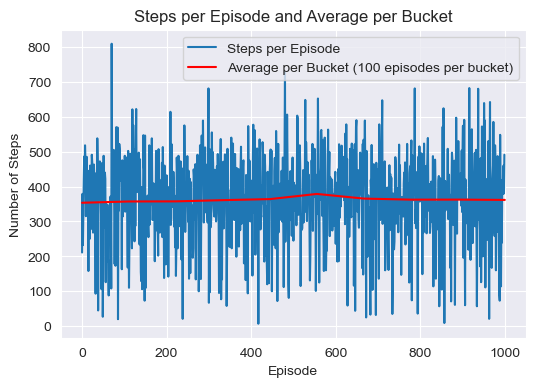

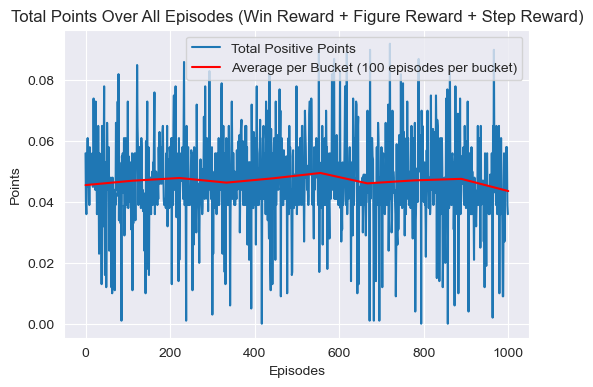

In [24]:
whether_action_from_Q_table(monte_carlo_results_random)
plot_steps(monte_carlo_results_random["mc_total_steps_per_episode"])
plot_points(monte_carlo_results_random["mc_total_positive_points"])
plot_losses(monte_carlo_results_random["mc_total_agent_losses_per_episode"], 
            monte_carlo_results_random["mc_total_enemy_losses_per_episode"])

### 3.1.2. Monte Carlo vs. Stockfish

In [ ]:
def Monte_Carlo_vs_Stockfish(Stockfish_path, n_episodes, elo_rating= 1, epsilon_decay= True, visit='first_visit'):
    """
    - Monte Carlo vs Stockfish.
    - Extra reward shaping is used to speed up the learning process.
    - If agent stays longer in the game, it gets a reward.
    - If agent captures a piece, it gets a reward.

    Args:
    --
        Stockfish_path (str): the path to the Stockfish engine
        n_episodes (int): the number of episodes to train the agent
        elo_rating (int): elo rating for the stockfish player
        epsilon_decay (bool): whether to decay the epsilon value or not
        visit (str): whether to use 'first_visit' or 'every_visit' Monte Carlo

    Returns:
    --
        monte_carlo_results (dict): 
        - a dictionary containing the Q_values,
        - the total positive points, the total agent losses per episode, 
        - the total enemy losses per episode, the total steps per episode, 
        - and the number of actions taken from the Q-table.
    """

    mc_Q_table = initialize_q_table()
    visit_counts = {}
    num_action_from_Q_table = {}
    decay_rate = 1 / n_episodes

    # Initialize the tracking variables
    mc_total_positive_points = []
    mc_total_agent_losses_per_episode = [] 
    mc_total_enemy_losses_per_episode = []
    mc_total_steps_per_episode = []
    

    for episode in range(n_episodes):
        print("NEW EPISODE")

        stockfish = Stockfish(Stockfish_path)
        stockfish.set_elo_rating(elo_rating)

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0
        discount_factor = 0.95
        step_reward = 0
        episode_positive_points = 0

        # Initialize epsilon for the episode.
        epsilon = new_epsilon(max_epsilon=MAX_EPSILON, 
                              min_epsilon=MIN_EPSILON, 
                              decay_rate=decay_rate, 
                              episode=episode) if epsilon_decay else 1
        
        # Initialize episode-specific tracking variables.
        agent_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(6, 12)}
        enemy_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(0, 6)}
        episode_agent_losses = {key: 0 for key in range(6, 12)}
        episode_enemy_losses = {key: 0 for key in range(0, 6)}

        episode_states_actions_rewards = []
        episode_rewards = []

        while not done:
            if step % 2 == 0:  # WHITE PLAYER'S TURN
                epsilon_action, num_action_from_Q_table = epsilon_greedy_policy(mc_Q_table, state, epsilon, episode, num_action_from_Q_table)
                action_white = epsilon_action
                decoded_action = str(ENV.decode(action_white))
                stockfish.make_moves_from_current_position([decoded_action])
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]

                # Reward shaping block.
                # If the agent does a step without getting beaten by stockfish it gets a reward.
                if reward == 0:
                    step_reward += STEP_REWARDS
                # Gets extra reward if it captures an enemy piece
                extra_points, agent_piece_losses, enemy_piece_losses = points_pieces(next_state, enemy_dict, agent_dict)
                episode_positive_points += extra_points

                # Update scores and losses.
                for piece in agent_piece_losses:
                    episode_agent_losses[piece] += agent_piece_losses[piece]
                for piece in enemy_piece_losses:
                    episode_enemy_losses[piece] += enemy_piece_losses[piece]

                # Calculates the total reward for Q_table update
                total_reward = reward + extra_points + step_reward

                # Store the results of this timestep.
                episode_states_actions_rewards.append((state, action_white, total_reward))
                episode_rewards.append(total_reward)

                state = next_state
                
            else:  # BLACK PLAYER'S TURN
                decoded_action = stockfish.get_best_move()
                action = ENV.encode(chess.Move.from_uci(decoded_action))
                stockfish.make_moves_from_current_position([decoded_action])
                next_state, reward, done, _ = ENV.step(action)
                next_state = next_state[:,:,:12]
                state = next_state

            step += 1

        # Now that the episode has ended, we can do the Monte Carlo update
        # calculate returns for each state that occurred in the episode
        for idx, (state, action, reward) in enumerate(episode_states_actions_rewards):
            G = sum([r * (discount_factor ** i) for i, r in enumerate(episode_rewards[idx:])])
            state_key = str(state)
            action_key = action
            # check if the state and action are in the Q table
            if state_key not in mc_Q_table:
                mc_Q_table[state_key] = {}
            if action_key not in mc_Q_table[state_key]:
                mc_Q_table[state_key][action_key] = []
            # if first visit MC, check if the state has been visited before
            if visit == 'first_visit':
                # append the return G to the Q table
                mc_Q_table[state_key][action_key].append(G)
            # if every visit MC, append the return G to the Q table and average over visits
            elif visit == 'every_visit':
                if state_key not in visit_counts:
                    visit_counts[state_key] = {}
                if action_key not in visit_counts[state_key]:
                    visit_counts[state_key][action_key] = 0
                visit_counts[state_key][action_key] += 1
                mc_Q_table[state_key][action_key].append(G / visit_counts[state_key][action_key])

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        print(f"Total episodes: {episode + 1} | Steps: {step} | Result: {result}")

        # Add episode scores to total scores
        mc_total_positive_points.append(episode_positive_points)
        mc_total_agent_losses_per_episode.append(episode_agent_losses)
        mc_total_enemy_losses_per_episode.append(episode_enemy_losses)
        mc_total_steps_per_episode.append(step)

        ENV.close() 

        monte_carlo_results = { "mc_Q_table": mc_Q_table,
                                "mc_total_positive_points": mc_total_positive_points,
                                "mc_total_agent_losses_per_episode": mc_total_agent_losses_per_episode,
                                "mc_total_enemy_losses_per_episode": mc_total_enemy_losses_per_episode,
                                "mc_total_steps_per_episode": mc_total_steps_per_episode,
                                "num_action_from_Q_table": num_action_from_Q_table,
                                }
        
        if episode % 20 == 0:
            save_object(monte_carlo_results, f"monte_carlo_results.pkl")

    return monte_carlo_results

In [ ]:
monte_carlo_results_stockfish = Monte_Carlo_vs_Stockfish(STOCKFISH_PATH, 1000, visit='every_visit')

No actions have been taken from the Q-table. The action space is too large!


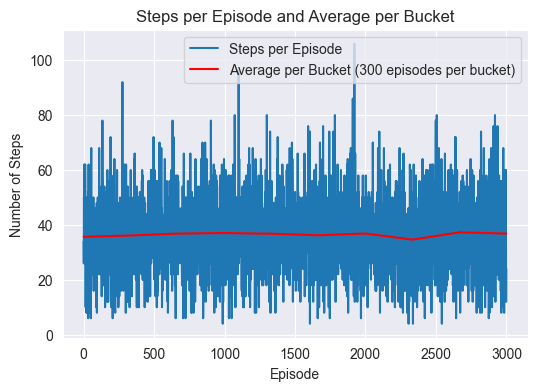

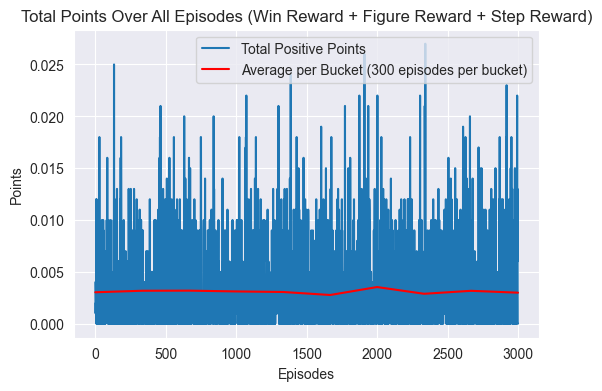

In [ ]:
whether_action_from_Q_table(monte_carlo_results_stockfish)
plot_steps(monte_carlo_results_stockfish["mc_total_steps_per_episode"])
plot_points(monte_carlo_results_stockfish["mc_total_positive_points"])

## 3.2. Q-learning

### 3.2.1. Agent vs. Agent

In [ ]:
def Q_learning_white(n_episodes=100, learning_rate=0.7, discount_factor=0.95, epsilon_decay=True):
    """
    Uses Q-learning Temporal Difference to train two agents, one white and one black, to play chess.
    """

    Q_table_white = initialize_q_table()
    Q_table_black = initialize_q_table()

    for episode in range(n_episodes):

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0

        epsilon = new_epsilon(1, 0.01, 0.005, episode) if epsilon_decay else 1

        while not done:         
            if step % 2 == 0:
                action_white = epsilon_greedy_policy(state, Q_table_white, epsilon)
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]
                # print(f"Next state shape: {next_state.shape}")
                # display_board(ENV, step)
                Q_update_q_table(state, action_white, reward, next_state, 
                                Q_table_white, learning_rate, discount_factor)
                state = next_state
        
            else:
                action_black = epsilon_greedy_policy(state, Q_table_black, epsilon)
                next_state, reward, done, _ = ENV.step(action_black)
                next_state = next_state[:,:,:12]
                # display_board(ENV, step)
                Q_update_q_table(state[:,:,:12], action_black, reward, next_state[:,:,:12], 
                                Q_table_black, learning_rate, discount_factor)
                state = next_state

            step += 1
        
        if (episode + 1) % 50 == 0:
            print(f"Total episodes: {episode + 1}")

        ENV.close()

    return Q_table_white, Q_table_black

In [ ]:
num_episodes = 10

Q_table_white, Q_table_black = Q_learning_white(num_episodes)

Q_table = {**Q_table_white, **Q_table_black}

total_q_values_white = calculate_total_q_values(Q_table_white)
total_q_values_black = calculate_total_q_values(Q_table_black)
print(f"Total sum of Q_values white: {total_q_values_white}")
print(f"Total sum of Q_values black: {total_q_values_black}")

Total sum of Q_values white: 0.0
Total sum of Q_values black: -0.7


### 3.2.2. Q-learning vs. Random Agent

In [22]:
def Q_learning_vs_Random(n_episodes, Qtable=None, epsilon_decay=True):
    """
    - Extra reward shaping is used to speed up the learning process.
    - If agent stays longer in the game, it gets a reward.
    - If agent captures a piece, it gets a reward.

    Args:
    --
        n_episodes (int): the number of episodes to train the agent
        Qtable (dict): the Q-table to use for training
        epsilon_decay (bool): whether to use epsilon decay or not

    Returns:
    --
        Q_learning_results (dict): 
        - a dictionary containing the Q-table,
        - the total positive points, the total agent losses per episode, 
        - the total enemy losses per episode, the total steps per episode, 
        - and the number of actions taken from the Q-table.
    """
    
    if Qtable is None:
        Q_table = initialize_q_table()
    else:
        Q_table = Qtable
    
    decay_rate = 1 / n_episodes
    
    # Initialize the tracking variables
    total_positive_points = []
    total_agent_losses_per_episode = []
    total_enemy_losses_per_episode = []  
    total_steps_per_episode = []         
    num_action_from_Q_table = {}

    for episode in range(n_episodes):
        print("NEW EPISODE")

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0
        learning_rate = 0.7
        discount_factor = 0.95
        step_reward = 0
        episode_positive_points = 0

        # Define the epsilon value and decay rate for epsilon.
        epsilon = new_epsilon(MAX_EPSILON, MIN_EPSILON, decay_rate, episode) if epsilon_decay else 1
        
        # Initialize episode-specific tracking variables
        agent_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(6, 12)}
        enemy_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(0, 6)}
        episode_agent_losses = {key: 0 for key in range(6, 12)}
        episode_enemy_losses = {key: 0 for key in range(0, 6)}

        while not done:
            if step % 2 == 0:  # WHITE PLAYER'S TURN
                epsilon_action, num_action_from_Q_table = epsilon_greedy_policy(Q_table, state, epsilon, episode, num_action_from_Q_table)
                action_white = epsilon_action
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]
                
                # If the agent does a step, it gets a reward.
                if reward == 0:
                    step_reward += STEP_REWARDS

                # Gets extra reward if it captures an enemy piece.
                extra_points, agent_piece_losses, enemy_piece_losses = points_pieces(next_state, enemy_dict, agent_dict)
                episode_positive_points += extra_points

                # Update the tracking variables.
                for piece in agent_piece_losses:
                    episode_agent_losses[piece] += agent_piece_losses[piece]
                for piece in enemy_piece_losses:
                    episode_enemy_losses[piece] += enemy_piece_losses[piece]

                # Calculates the total reward for Q_table update.
                total_reward = reward + extra_points + step_reward
                Q_update_q_table(state, action_white, total_reward, next_state, 
                                 Q_table, learning_rate, discount_factor)
                
                state = next_state
                
            else:  # BLACK PLAYER'S TURN
                action = random_action(ENV)
                next_state, reward, done, _ = ENV.step(action)
                next_state = next_state[:,:,:12]
                state = next_state

            step += 1

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        print(f"Total episodes: {episode + 1} | Steps: {step} | Result: {result}")

        # Add episode scores to total scores
        total_positive_points.append(episode_positive_points)
        total_agent_losses_per_episode.append(episode_agent_losses)
        total_enemy_losses_per_episode.append(episode_enemy_losses)
        total_steps_per_episode.append(step)

        ENV.close()

        Q_learning_results = {
                            "Q_table": Q_table,
                            "total_positive_points": total_positive_points,
                            "total_agent_losses_per_episode": total_agent_losses_per_episode,
                            "total_enemy_losses_per_episode": total_enemy_losses_per_episode,
                            "total_steps_per_episode": total_steps_per_episode,
                            "num_action_from_Q_table": num_action_from_Q_table}
        
        if episode % 50 == 0:
            save_object(Q_learning_results, f"Q_learning_results_random.pkl")

    return Q_learning_results

In [ ]:
Q_learning_results_random = Q_learning_vs_Random(1000, epsilon_decay=True)

No actions have been taken from the Q-table. The action space is too large!


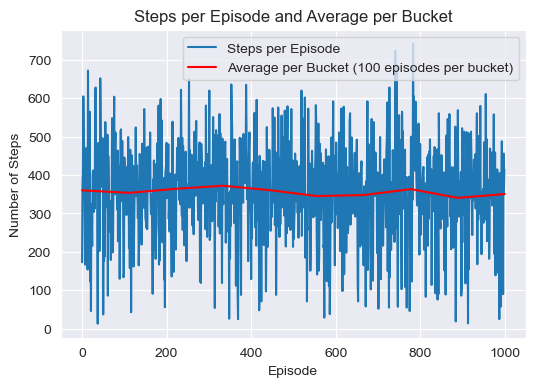

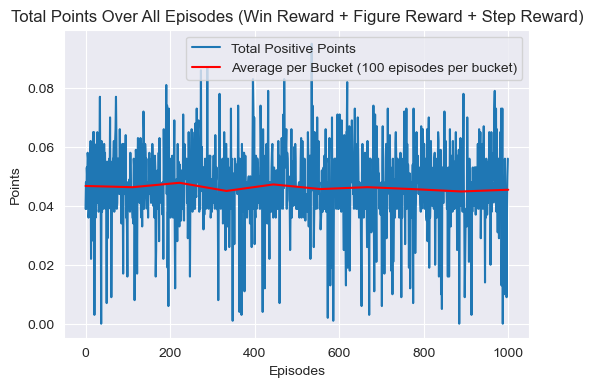

In [24]:
whether_action_from_Q_table(Q_learning_results_random)
plot_steps(Q_learning_results_random["total_steps_per_episode"])
plot_points(Q_learning_results_random["total_positive_points"])
plot_losses(Q_learning_results_random["total_agent_losses_per_episode"], Q_learning_results_random["total_enemy_losses_per_episode"])

### 3.2.2. Q-learning vs. Stockfish

In [ ]:
def Q_learning_vs_Stockfish(Stockfish_path, n_episodes, elo_rating=1, Qtable=None, epsilon_decay=True):
    """
    - Q-learning vs Stockfish.
    - Extra reward shaping is used to speed up the learning process.
    - If agent stays longer in the game, it gets a reward.
    - If agent captures a piece, it gets a reward.

    Args:
    --
        Stockfish_path (str): the path to the Stockfish engine
        n_episodes (int): the number of episodes to train the agent
        elo_rating (int): the elo rating of the Stockfish engine
        Qtable (dict): the Q-table to use for training
        epsilon_decay (bool): whether to use epsilon decay or not

    Returns:
    --
        Q_learning_results (dict): 
        - a dictionary containing the Q-table,
        - the total positive points, the total agent losses per episode, 
        - the total enemy losses per episode, the total steps per episode, 
        - and the number of actions taken from the Q-table.
    """
    
    if Qtable is None:
        Q_table = initialize_q_table()
    else:
        Q_table = Qtable
    
    # Initialize the tracking variables
    total_positive_points = []
    total_agent_losses_per_episode = []
    total_enemy_losses_per_episode = []  
    total_steps_per_episode = []         
    num_action_from_Q_table = {}
    
    decay_rate = 1 / n_episodes

    for episode in range(n_episodes):
        print("NEW EPISODE")

        stockfish = Stockfish(Stockfish_path)
        stockfish.set_elo_rating(elo_rating)

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0
        learning_rate = 0.7
        discount_factor = 0.95
        step_reward = 0
        episode_positive_points = 0

        # Define the epsilon value and decay rate for epsilon.
        epsilon = new_epsilon(MAX_EPSILON, MIN_EPSILON, decay_rate, episode) if epsilon_decay else 1
        
        # Initialize episode-specific tracking variables
        agent_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(6, 12)}
        enemy_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(0, 6)}
        episode_agent_losses = {key: 0 for key in range(6, 12)}
        episode_enemy_losses = {key: 0 for key in range(0, 6)}

        while not done:
            if step % 2 == 0:  # WHITE PLAYER'S TURN
                epsilon_action, num_action_from_Q_table = epsilon_greedy_policy(Q_table, state, epsilon, episode, num_action_from_Q_table)
                action_white = epsilon_action
                decoded_action = str(ENV.decode(action_white))
                stockfish.make_moves_from_current_position([decoded_action])
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]

                # If the agent does a step without getting beaten by stockfish it gets a reward.
                if reward == 0:
                    step_reward += STEP_REWARDS

                # Gets extra reward if it captures an enemy piece.
                extra_points, agent_piece_losses, enemy_piece_losses = points_pieces(next_state, enemy_dict, agent_dict)
                episode_positive_points += extra_points

                # Update the tracking variables.
                for piece in agent_piece_losses:
                    episode_agent_losses[piece] += agent_piece_losses[piece]
                for piece in enemy_piece_losses:
                    episode_enemy_losses[piece] += enemy_piece_losses[piece]

                # Calculates the total reward for Q_table update
                total_reward = reward + extra_points + step_reward

                Q_update_q_table(state, action_white, total_reward, next_state, 
                                 Q_table, learning_rate, discount_factor)
                
                state = next_state
                
            else:  # BLACK PLAYER'S TURN
                decoded_action = stockfish.get_best_move()
                action = ENV.encode(chess.Move.from_uci(decoded_action))
                stockfish.make_moves_from_current_position([decoded_action])
                next_state, reward, done, _ = ENV.step(action)
                next_state = next_state[:,:,:12]
                state = next_state

            step += 1

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        print(f"Total episodes: {episode + 1} | Steps: {step} | Result: {result}")

        # Add episode scores to total scores.
        total_positive_points.append(episode_positive_points)
        total_agent_losses_per_episode.append(episode_agent_losses)
        total_enemy_losses_per_episode.append(episode_enemy_losses)
        total_steps_per_episode.append(step)

        ENV.close()

        Q_learning_results = {
                            "Q_table": Q_table,
                            "total_positive_points": total_positive_points,
                            "total_agent_losses_per_episode": total_agent_losses_per_episode,
                            "total_enemy_losses_per_episode": total_enemy_losses_per_episode,
                            "total_steps_per_episode": total_steps_per_episode,
                            "num_action_from_Q_table": num_action_from_Q_table}
        
        if episode % 50 == 0:
            save_object(Q_learning_results, f"Q_learning_results.pkl")

    return Q_learning_results

In [ ]:
Q_learning_results_stockfish = Q_learning_vs_Stockfish(STOCKFISH_PATH, 1000)

No actions have been taken from the Q-table. The action space is too large!


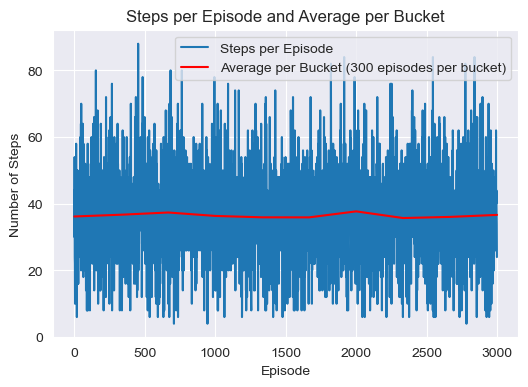

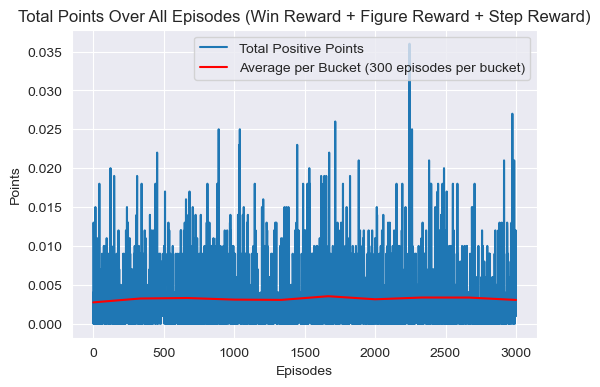

In [ ]:
whether_action_from_Q_table(Q_learning_results_stockfish)
plot_steps(Q_learning_results_stockfish["total_steps_per_episode"])
plot_points(Q_learning_results_stockfish["total_positive_points"])
plot_losses(Q_learning_results_stockfish["total_agent_losses_per_episode"], Q_learning_results_stockfish["total_enemy_losses_per_episode"])

## 3.3. Deep Q-learning

### 3.3.1. DQN vs. Random Agent

In [28]:
def DQN_vs_random(n_episodes, load_agent=False, epsilon_decay=False, greedy=False, checkpoint_path=None):
    """
    Trains a DQN agent against a random agent.
    - Extra reward shaping is used to speed up the learning process.
    - If agent stays longer in the game, it gets a reward.
    - If agent captures a piece, it gets a reward.

    Args:
    --
        n_episodes (int): the number of episodes to train the agent
        load_agent (bool): whether to load the agent from a checkpoint or not
        epsilon_decay (bool): whether to use epsilon decay or not
        greedy (bool): whether to use greedy policy or not
        checkpoint_path (str): the path to the checkpoint to load the agent from

    Returns:
    --
        DQN_results (dict): 
        - the total positive points, the total agent losses per episode, 
        - the total enemy losses per episode, the total steps per episode, 
        - and the number of actions taken from the Q-table,
    """
    # Initialize agent, target agent and replay memory.
    agent, target_agent = create_or_load_agent(load_agent, checkpoint_path)
    replay_memory = deque(maxlen=10000)

    epsilon_decay_rate = 1 / n_episodes

    # Initialize the tracking variables
    total_positive_points = []
    total_agent_losses_per_episode = []
    total_enemy_losses_per_episode = []
    total_steps_per_episode = []       
    DQN_loss_overtime = []

    for episode in range(n_episodes):
        print("NEW EPISODE")

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0
        step_reward = 0
        episode_positive_points = 0

        # Update epsilon of the agent.
        agent.epsilon = new_epsilon(MAX_EPSILON, MIN_EPSILON, epsilon_decay_rate, episode) if epsilon_decay else 1

        # Initialize episode-specific tracking variables
        agent_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(6, 12)}
        enemy_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(0, 6)}
        episode_agent_losses = {key: 0 for key in range(6, 12)}
        episode_enemy_losses = {key: 0 for key in range(0, 6)}

        while not done:
            if step % 2 == 0:  
                # WHITE PLAYER'S TURN
                q_values = agent.get_q_values([state])
                action_white = (q_values.argmax(axis=-1)[0] if greedy else agent.sample_actions(q_values)[0])
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]

                # If the agent does a step it gets a reward, to stay longer in the game.
                if reward == 0:
                    step_reward += STEP_REWARDS

                # Gets extra reward if it captures an enemy piece.
                extra_points, agent_piece_losses, enemy_piece_losses = points_pieces(next_state, enemy_dict, agent_dict)
                episode_positive_points += extra_points

                # Update the tracking variables.
                for piece in agent_piece_losses:
                    episode_agent_losses[piece] += agent_piece_losses[piece]
                for piece in enemy_piece_losses:
                    episode_enemy_losses[piece] += enemy_piece_losses[piece]

                # Calculates the total reward for Q_table update.
                total_reward = reward + extra_points + step_reward
                
                # Add the experience to replay memory.
                replay_memory.append([state, action_white, total_reward, next_state, done])

                # Train the agent.
                if step % 30 == 0 or done:
                    loss = train_agent(replay_memory, agent, target_agent, done)
                    DQN_loss_overtime.append(loss)
                
                state = next_state
                
            else:  
                # BLACK PLAYER'S TURN
                action = random_action(ENV)
                next_state, reward, done, _ = ENV.step(action)
                next_state = next_state[:,:,:12]
                state = next_state

            step += 1

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        print(f"Total episodes: {episode + 1} | Steps: {step} | Result: {result}")

        ENV.close()

        # Add episode scores to total scores.
        total_positive_points.append(episode_positive_points)
        total_agent_losses_per_episode.append(episode_agent_losses)
        total_enemy_losses_per_episode.append(episode_enemy_losses)
        total_steps_per_episode.append(step)

        ENV.close()

        DQN_results = { "total_positive_points": total_positive_points,
                        "total_agent_losses_per_episode": total_agent_losses_per_episode,
                        "total_enemy_losses_per_episode": total_enemy_losses_per_episode,
                        "total_steps_per_episode": total_steps_per_episode}
                        # "loss": DQN_loss_overtime}
        
        if episode % 100 == 0:
            print(f'Copying agent weights to the target agent weights')
            target_agent.load_state_dict(agent.state_dict())

        if episode % 20 == 0:
            print(f"Saving agent checkpoint and results.")
            torch.save(agent.state_dict(), checkpoint_path)
            save_object(DQN_results, f"DQN_results_random")

    return DQN_results, agent

In [ ]:
checkpoint_path_random = 'checkpoints/agent_checkpoint_random.pth'
load_agent = False

DQN_results_random, agent_random = DQN_vs_random(n_episodes=1000,
                                    load_agent=load_agent,
                                    epsilon_decay=True, 
                                    greedy=False,
                                    checkpoint_path=checkpoint_path_random)

torch.save(agent_random.state_dict(), checkpoint_path_random)
save_object(DQN_results_random, f"DQN_results_random")

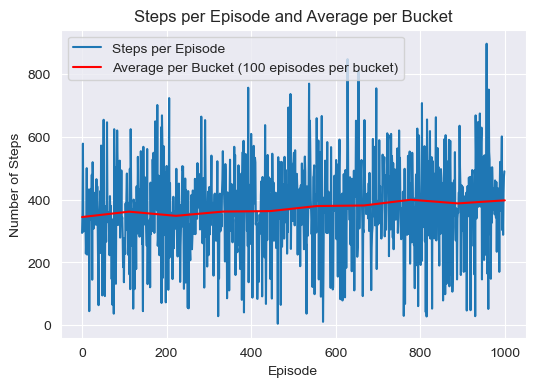

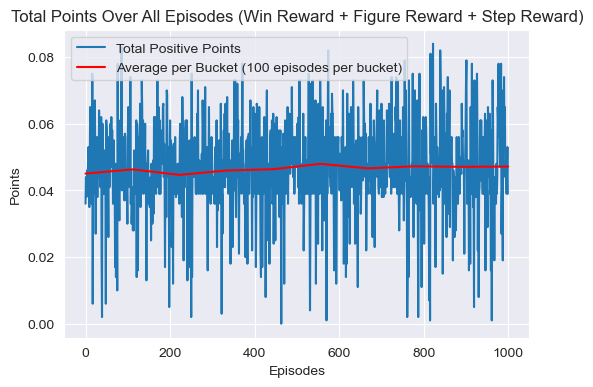

In [25]:
plot_steps(DQN_results_random["total_steps_per_episode"])
plot_points(DQN_results_random["total_positive_points"])
plot_losses(DQN_results_random["total_agent_losses_per_episode"], DQN_results_random["total_enemy_losses_per_episode"])

### 3.3.2. DQN vs. Stockfish

In [ ]:
def DQN_vs_Stockfish(Stockfish_path, n_episodes, load_agent=False, elo_rating = 1, epsilon_decay=False, greedy=False, checkpoint_path=None):
    """
    Trains a DQN agent against Stockfish.
    - Extra reward shaping is used to speed up the learning process.
    - If agent stays longer in the game, it gets a reward.
    - If agent captures a piece, it gets a reward.

    Args:
    --
        Stockfish_path (str): the path to the Stockfish engine
        n_episodes (int): the number of episodes to train the agent
        load_agent (bool): whether to load the agent from a checkpoint or not
        elo_rating (int): the elo rating of Stockfish
        epsilon_decay (bool): whether to use epsilon decay or not
        greedy (bool): whether to use greedy policy or not
        checkpoint_path (str): the path to the checkpoint to load the agent from

    Returns:
    --
        DQN_results (dict): 
        - the total positive points, the total agent losses per episode, 
        - the total enemy losses per episode, the total steps per episode, 
        - and the number of actions taken from the Q-table,
        - loss of the model.
    """
    # Initialize agent, target agent and replay memory.
    agent, target_agent = create_or_load_agent(load_agent, checkpoint_path)
    replay_memory = deque(maxlen=10000)

    epsilon_decay_rate = 1 / n_episodes

    # Initialize the tracking variables
    total_positive_points = []
    total_agent_losses_per_episode = []
    total_enemy_losses_per_episode = []
    total_steps_per_episode = []       
    DQN_loss_overtime = []

    for episode in range(n_episodes):
        print("NEW EPISODE")

        stockfish = Stockfish(Stockfish_path)
        stockfish.set_elo_rating(elo_rating)

        state = ENV.reset()
        state = state[:,:,:12]
        done = False
        step = 0
        step_reward = 0

        agent.epsilon = new_epsilon(MAX_EPSILON, MIN_EPSILON, epsilon_decay_rate, episode) if epsilon_decay else 1

        # Initialize episode-specific tracking variables
        
        agent_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(6, 12)}
        enemy_dict = {key: [PIECES_QUANTITY[key], 0] for key in range(0, 6)}
        episode_positive_points = 0
        episode_agent_losses = {key: 0 for key in range(6, 12)}
        episode_enemy_losses = {key: 0 for key in range(0, 6)}

        while not done:
            if step % 2 == 0:  
                # WHITE PLAYER'S TURN
                q_values = agent.get_q_values([state])
                action_white = (q_values.argmax(axis=-1)[0] if greedy else agent.sample_actions(q_values)[0])
                decoded_action = str(ENV.decode(action_white))
                stockfish.make_moves_from_current_position([decoded_action])
                next_state, reward, done, _ = ENV.step(action_white)
                next_state = next_state[:,:,:12]

                # If the agent does a step without getting beaten by stockfish it gets a reward
                if reward == 0:
                    step_reward += STEP_REWARDS

                # Gets extra reward if it captures an enemy piece
                extra_points, agent_piece_losses, enemy_piece_losses = points_pieces(next_state, enemy_dict, agent_dict)
                episode_positive_points += extra_points

                # Punkte und Verluste aktualisieren
                for piece in agent_piece_losses:
                    episode_agent_losses[piece] += agent_piece_losses[piece]
                for piece in enemy_piece_losses:
                    episode_enemy_losses[piece] += enemy_piece_losses[piece]

                # Calculates the total reward for Q_table update
                total_reward = reward + extra_points + step_reward
                
                replay_memory.append([state, action_white, total_reward, next_state, done])

                if step % 30 == 0 or done:
                    loss = train_agent(replay_memory, agent, target_agent, done)
                    DQN_loss_overtime.append(loss)
                
                state = next_state
                
            else:  
                # BLACK PLAYER'S TURN
                decoded_action = stockfish.get_best_move()
                action = ENV.encode(chess.Move.from_uci(decoded_action))
                stockfish.make_moves_from_current_position([decoded_action])
                next_state, reward, done, _ = ENV.step(action)
                next_state = next_state[:,:,:12]
                state = next_state

            step += 1

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        print(f"Total episodes: {episode + 1} | Steps: {step} | Result: {result}")

        ENV.close()

        # Add episode scores to total scores.
        total_positive_points.append(episode_positive_points)
        total_agent_losses_per_episode.append(episode_agent_losses)
        total_enemy_losses_per_episode.append(episode_enemy_losses)
        total_steps_per_episode.append(step)

        ENV.close()

        DQN_results = { "total_positive_points": total_positive_points,
                        "total_agent_losses_per_episode": total_agent_losses_per_episode,
                        "total_enemy_losses_per_episode": total_enemy_losses_per_episode,
                        "total_steps_per_episode": total_steps_per_episode,
                        "loss": DQN_loss_overtime}
        
        if episode % 100 == 0:
            print(f'Copying agent weights to the target agent weights')
            target_agent.load_state_dict(agent.state_dict())

        if episode % 20 == 0:
            print(f"Saving agent checkpoint and results.")
            torch.save(agent.state_dict(), checkpoint_path)
            save_object(DQN_results, f"DQN_results.pkl")

    return DQN_results, agent

In [ ]:
checkpoint_path_stockfish = "checkpoints/agent_checkpoint_stockfish.pth"
load_agent = True

DQN_results_stockfish, agent_stockfish = DQN_vs_Stockfish(STOCKFISH_PATH, 
                                                        n_episodes=500,
                                                        load_agent=load_agent,
                                                        elo_rating=1, 
                                                        epsilon_decay=True, 
                                                        greedy=False,
                                                        checkpoint_path=checkpoint_path_stockfish)

torch.save(agent_stockfish.state_dict(), checkpoint_path_stockfish)
save_object(DQN_results_stockfish, f"DQN_results_stockfish")

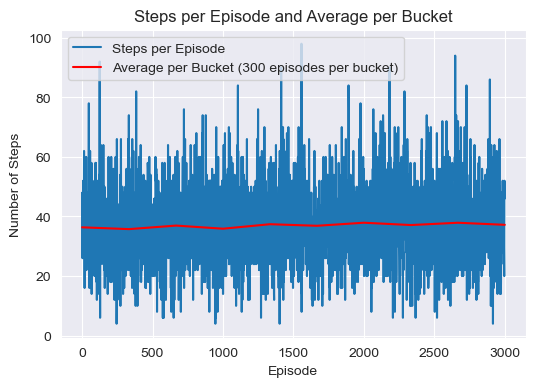

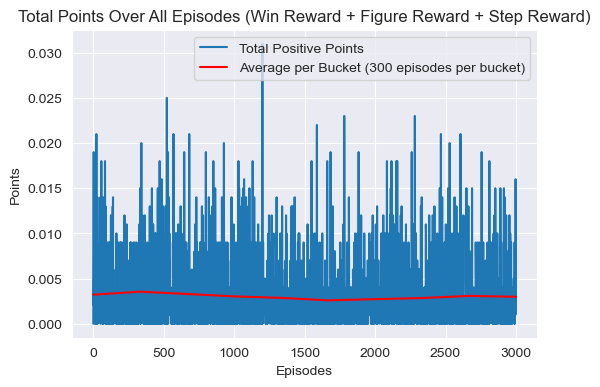

In [ ]:
plot_steps(DQN_results_stockfish["total_steps_per_episode"])
plot_points(DQN_results_stockfish["total_positive_points"])
plot_losses(DQN_results_stockfish["total_agent_losses_per_episode"], 
            DQN_results_stockfish["total_enemy_losses_per_episode"])